# Working with Data - Computer Lab for Guest Lecture Julia Lane

In this computer lab we will learn more more details and practice data work to enhance the content of the lecture presented by Julia Lane on responsible data use. We will address a research question, think about data and measurement errors, and manipulate data. 

OUTLINE: 
1. Define a research question 
2. Think about what data are available 
3. Think about possible measurement errors 
4. Think about the interpretation of your results 
5. Inform your results by linking datasets 

# 1. Define a reserach question
Which Community Districts in NYC show the highest number of complaints?

# 2. Think about what data are available
Find suitable data by searching the CUSP Data Catalog https://datahub.cusp.nyu.edu/catalog. You can use Urban Profiler to investigate the Metadata associated with each dataset. Using this tool will help you to decide which attributes of the data you need to answer your question so you don't have to load the entire dataset. 

In [230]:
import os
import pandas as pd
import numpy as np
import re
PUIdata = os.getenv('PUIDATA')
DFDATA = (os.getenv('DFDATA'))
import geopandas as gp
import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
print(os.getenv('DFDATA'))
#/gws/open/NYCOpenData/nycopendata/data/erm2-nwe9

/gws/open/NYCOpenData/nycopendata/data


In [7]:
data311 = pd.read_csv(os.getenv("DFDATA") + "/erm2-nwe9/1446832678/erm2-nwe9")

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8,17,39,40,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
data311.shape

(10187766, 53)

In [9]:
data311.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [10]:
d311 = data311[['Unique Key', 'Agency Name', 'Complaint Type', 'Descriptor', 
       'Resolution Description', 'Community Board',
       'Borough', 'Latitude', 'Longitude', 'Location']]

In [11]:
d311.head()

,Unique Key,Agency Name,Complaint Type,Descriptor,Resolution Description,Community Board,Borough,Latitude,Longitude,Location
0,31911011,Department of Transportation,Street Condition,Pothole,NaN,13 BROOKLYN,BROOKLYN,40.573431,-73.991742,"(40.57343122248129, -73.99174247588253)"
1,31908754,CHALL,Opinion for the Mayor,HOUSING,Your comments have been submitted to the Mayor...,0 Unspecified,Unspecified,NaN,NaN,NaN
2,31910423,Department of Parks and Recreation,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,18 BROOKLYN,BROOKLYN,40.625004,-73.920726,"(40.62500363580505, -73.92072558378698)"
3,31909924,New York City Police Department,Illegal Parking,Blocked Hydrant,Your complaint has been received by the Police...,12 BROOKLYN,BROOKLYN,40.634522,-73.974790,"(40.634522428879706, -73.97479041437481)"
4,31913310,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,The Human Resources Administration received yo...,0 Unspecified,Unspecified,NaN,NaN,NaN


# 3. Think about possible measurement errors
Do you see any problems regarding possible measurement error? Think about who is represented in the data, ommissions, duplications, content error, missing data, etc. 

In [107]:
# How many unique values do we have? 
# Check for duplicates? Are these plausible?
d311_unq = d311.drop_duplicates()
len(d311_unq)

10187766

After dropping duplicates, the size of the dataset remains the same indicating a number of unique values equal to the original; no duplicates.

In [49]:
d311_board = d311['Community Board'].str.split(' ', 1, expand=True)
print(d311_board.shape)
d311_board.groupby(1).count()

(10187766, 2)


,0
1,
BRONX,1665625
BROOKLYN,2831932
MANHATTAN,1900005
QUEENS,2189760
STATEN ISLAND,490998
Unspecified,1109446


The listed borough in the original dataset and the borough identified in the community board do not match which indicate some data cleanup is required.

In [12]:
# Check if all Boroughs and Community Districts are represented in the Data
d311.groupby('Borough').size()

Borough
BRONX            1665625
BROOKLYN         2831932
MANHATTAN        1900005
QUEENS           2189760
STATEN ISLAND     490998
Unspecified      1109446
dtype: int64

All boroughs are represented but there are 1057347 unspecified records.

In [13]:
d311.groupby('Community Board').size().count()

77

There are 77 community Boards listed whereas there should only be 59.

In [14]:
# Why do we have so many? Some of them are unspecified, missing. Some might be invalid entries. 
# We should have 59 Community Districts.
#data311_59 = data311.(data311.str.contains("Unspecified"))
# Check for duplicates? Are these plausible?
cln_d311 = sorted(set(d311['Community Board']))
len(cln_d311)

77

Even after being sorted and deduplicated, the list of community boards is still greater than 59.  The 18 invalid community boards must be identified.  The list of NYC community boards can be found here: https://en.wikipedia.org/wiki/Community_boards_of_New_York_City.

In [15]:
d311['Community Board'].unique()

array(['13 BROOKLYN', '0 Unspecified', '18 BROOKLYN', '12 BROOKLYN',
       '02 STATEN ISLAND', '08 MANHATTAN', '06 BROOKLYN', '10 BRONX',
       '06 MANHATTAN', '04 BROOKLYN', '04 QUEENS', '09 MANHATTAN',
       '14 BROOKLYN', '05 MANHATTAN', '02 MANHATTAN', '10 QUEENS',
       '07 QUEENS', '02 QUEENS', '11 BROOKLYN', '05 QUEENS', '05 BROOKLYN',
       '09 QUEENS', '12 MANHATTAN', '01 BROOKLYN', '11 MANHATTAN',
       '03 BRONX', '03 STATEN ISLAND', '08 BROOKLYN', '03 BROOKLYN',
       '07 MANHATTAN', '10 MANHATTAN', '04 BRONX', '01 MANHATTAN',
       '07 BRONX', '09 BRONX', '03 MANHATTAN', '13 QUEENS', '02 BRONX',
       '12 QUEENS', '16 BROOKLYN', '08 QUEENS', '04 MANHATTAN',
       '14 QUEENS', '10 BROOKLYN', '11 QUEENS', '06 BRONX', '08 BRONX',
       '05 BRONX', '15 BROOKLYN', '02 BROOKLYN', '12 BRONX', '03 QUEENS',
       '06 QUEENS', '01 STATEN ISLAND', '01 BRONX', '01 QUEENS',
       '17 BROOKLYN', '11 BRONX', 'Unspecified QUEENS', '09 BROOKLYN',
       'Unspecified MANHATTAN'

In [37]:
d311.head()

,Unique Key,Agency Name,Complaint Type,Descriptor,Resolution Description,Community Board,Borough,Latitude,Longitude,Location,Invalid_CB
0,31911011,Department of Transportation,Street Condition,Pothole,NaN,13 BROOKLYN,BROOKLYN,40.573431,-73.991742,"(40.57343122248129, -73.99174247588253)",N
1,31908754,CHALL,Opinion for the Mayor,HOUSING,Your comments have been submitted to the Mayor...,0 Unspecified,Unspecified,NaN,NaN,NaN,Y
2,31910423,Department of Parks and Recreation,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,18 BROOKLYN,BROOKLYN,40.625004,-73.920726,"(40.62500363580505, -73.92072558378698)",N
3,31909924,New York City Police Department,Illegal Parking,Blocked Hydrant,Your complaint has been received by the Police...,12 BROOKLYN,BROOKLYN,40.634522,-73.974790,"(40.634522428879706, -73.97479041437481)",N
4,31913310,HRA Benefit Card Replacement,Benefit Card Replacement,Medicaid,The Human Resources Administration received yo...,0 Unspecified,Unspecified,NaN,NaN,NaN,Y


In [35]:
# Generate marker for unplausible Community Districts
# How do these districts look like? 
d311['Invalid_CB'] = np.where(((d311['Community Board']=='0 Unspecified') | (d311['Community Board']=='Unspecified QUEENS') | 
                             (d311['Community Board']=='Unspecified MANHATTAN')|(d311['Community Board']=='Unspecified BROOKLYN')|
                             (d311['Community Board']=='Unspecified BRONX')|(d311['Community Board']=='81 QUEENS')|
                             (d311['Community Board']=='55 BROOKLYN')|(d311['Community Board']=='83 QUEENS')|
                             (d311['Community Board']=='Unspecified STATEN ISLAND')|(d311['Community Board']=='28 BRONX')|
                             (d311['Community Board']=='80 QUEENS')|(d311['Community Board']=='26 BRONX')|
                             (d311['Community Board']=='95 STATEN ISLAND')|(d311['Community Board']=='82 QUEENS')|
                             (d311['Community Board']=='27 BRONX')|(d311['Community Board']=='56 BROOKLYN')|
                             (d311['Community Board']=='84 QUEENS')|(d311['Community Board']=='64 MANHATTAN')), 'Y', 'N')
d311['Invalid_CB'].value_counts()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


N    8110945
Y    2076821
Name: Invalid_CB, dtype: int64

In [ ]:
d311.drop(['Latitude', 'Longitude', 'Location'], axis=1, inplace=True)

In [42]:
grp_d311 = d311.groupby('Invalid_CB')
grp_d311.describe()

Unique Key
Invalid_CB                    
N          count  8.110945e+06
           mean   2.516496e+07
           std    4.307954e+06
           min    1.056422e+07
           25%    2.181820e+07
           50%    2.548918e+07
           75%    2.891216e+07
           max    3.191561e+07
Y          count  2.076821e+06
           mean   2.200411e+07
           std    4.701772e+06
           min    1.146464e+07
           25%    1.855628e+07
           50%    2.003803e+07
           75%    2.595918e+07
           max    3.191558e+07

About 2M records are identifieds as belonging to an invalid community board. 

In [44]:
invld_CB = grp_d311.get_group('Y')
invld_CB['Complaint Type'].value_counts().head(10)

HEATING                     348869
Street Light Condition      274133
Street Condition            263655
GENERAL CONSTRUCTION        176378
PLUMBING                    155894
PAINT - PLASTER             127674
Traffic Signal Condition    126408
DOF Literature Request      125719
NONCONST                     92470
ELECTRIC                     54509
Name: Complaint Type, dtype: int64

In [45]:
# What about missing values? Can you detect any patterns? 
invld_CB.isnull().sum()

Agency Name                    0
Borough                        0
Community Board                0
Complaint Type                 0
Descriptor                   512
Resolution Description    765560
Unique Key                     0
dtype: int64

In [47]:
# Drop the marked districts
vld_CB = grp_d311.get_group('N')
print(vld_CB['Complaint Type'].value_counts().head(10))

HEATING                   539000
Blocked Driveway          372607
PLUMBING                  352940
Water System              338608
GENERAL CONSTRUCTION      324489
Street Condition          314578
Street Light Condition    308274
HEAT/HOT WATER            305091
Illegal Parking           268580
PAINT - PLASTER           233584
Name: Complaint Type, dtype: int64


vld_CB will be used moving forward thus dropping invalid community boards.

In [48]:
# What about missing values? Can you detect any patterns? 
print(vld_CB.isnull().sum())

Agency Name                     0
Borough                         0
Community Board                 0
Complaint Type                  0
Descriptor                  30545
Resolution Description    3021191
Unique Key                      0
dtype: int64


The above shows that there are null values in the descriptor and resolution description fields for both sets of CB validity groups.  Since there are no null values in the complaint type, we will use those values where resolution description is null.

In [51]:
vld_CB.head()

,Agency Name,Borough,Community Board,Complaint Type,Descriptor,Resolution Description,Unique Key
0,Department of Transportation,BROOKLYN,13 BROOKLYN,Street Condition,Pothole,NaN,31911011
2,Department of Parks and Recreation,BROOKLYN,18 BROOKLYN,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,31910423
3,New York City Police Department,BROOKLYN,12 BROOKLYN,Illegal Parking,Blocked Hydrant,Your complaint has been received by the Police...,31909924
5,Department of Transportation,STATEN ISLAND,02 STATEN ISLAND,Highway Condition,Pothole - Highway,The Department of Transportation requires 10 d...,31914148
7,New York City Police Department,MANHATTAN,08 MANHATTAN,Noise - Commercial,Loud Music/Party,Your complaint has been forwarded to the New Y...,31912611


In [50]:
# Data Editing: Is it possible to replace missing values? Is it possible to use Complaint Type 
# to fill missings in Resolution Descriptor?

In [52]:
vld_CB["Resolution Description"].fillna(value = vld_CB["Complaint Type"], inplace = True )
vld_CB.head()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,Agency Name,Borough,Community Board,Complaint Type,Descriptor,Resolution Description,Unique Key
0,Department of Transportation,BROOKLYN,13 BROOKLYN,Street Condition,Pothole,Street Condition,31911011
2,Department of Parks and Recreation,BROOKLYN,18 BROOKLYN,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,31910423
3,New York City Police Department,BROOKLYN,12 BROOKLYN,Illegal Parking,Blocked Hydrant,Your complaint has been received by the Police...,31909924
5,Department of Transportation,STATEN ISLAND,02 STATEN ISLAND,Highway Condition,Pothole - Highway,The Department of Transportation requires 10 d...,31914148
7,New York City Police Department,MANHATTAN,08 MANHATTAN,Noise - Commercial,Loud Music/Party,Your complaint has been forwarded to the New Y...,31912611


In [54]:
vld_CB.duplicated().group()

8110945

Checked for possible duplication, but found none.

In [139]:
# Produce your result: Generate an indicator which ranks the Community District by complaint numbers 
# on the Community district level
final_311 = vld_CB[['Community Board','Complaint Type']].groupby('Community Board').count()
final_311.rename(columns={'Complaint Type':'Number of Complaints'}, inplace=True)
d311_byCB = final_311.sort(['Number of Complaints'], ascending=[0])
d311_byCB

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Number of Complaints
Community Board,
12 MANHATTAN,268053
12 QUEENS,229383
03 BROOKLYN,197306
07 QUEENS,195961
17 BROOKLYN,191720
05 BROOKLYN,189765
14 BROOKLYN,187794
07 BRONX,185729
01 BROOKLYN,185057


In [63]:
# Safe reduced data frame (Community District level)
result.head(10)

,Number of Complaints
Community Board,
12 MANHATTAN,268053
12 QUEENS,229383
03 BROOKLYN,197306
07 QUEENS,195961
17 BROOKLYN,191720
05 BROOKLYN,189765
14 BROOKLYN,187794
07 BRONX,185729
01 BROOKLYN,185057


# 4. Think about the interpretation of your results?
What do you have to keep in mind when interpreting your results? Are they generable? Does the way the data is collected influence your results? To better inform city agancies it might be good to explore in more detail the underlying dempgraphics/infrastructure of a Community District becasue this might influence 311 calls. You can do this by merging external data on the Community District level to your analysis data. 

In [97]:
# Population by Community District
url = "http://cosmo.nyu.edu/~fb55/PUI2016/data/Final_Demographics.csv"
filename = "Final_Demographics.csv"

os.system("curl -O " + url)
print(os.getenv("PUIDATA"))
os.system("mv " + filename + " " + os.getenv("PUIDATA"))
df_pop = pd.read_csv(PUIdata + "/" + filename)

/home/cusp/fhl204/PUIdata


In [79]:
# Check variables in file
print(df_pop.shape)
#print(df_pop.count())
list(df_pop.columns.values)

(59, 158)


['FIPS',
 'cd_id',
 'Total Population',
 'Population Density (per sq. mile)',
 '% Total Population: Male',
 '% Total Population: 18 to 24 Years',
 '% Total Population: 25 to 34 Years',
 '% Total Population: 35 to 44 Years',
 '% Population 5 Years And Over: Speak Only English',
 '% Population 5 Years And Over: Spanish or Spanish Creole',
 '% Population 5 Years And Over: Spanish or Spanish Creole: Speak English "very Well"',
 '% Population 5 Years And Over: Spanish or Spanish Creole: Speak English Less Than "very Well"',
 'Population 25 Years and over:',
 'Population 25 Years and over: Less Than High School',
 'Population 25 Years and over: High School Graduate (includes equivalency)',
 'Population 25 Years and over: Some college',
 "Population 25 Years and over: Bachelor's degree",
 "Population 25 Years and over: Master's degree",
 'Population 25 Years and over: Professional school degree',
 'Population 25 Years and over: Doctorate degree',
 '% Population 25 Years and over: Less Than Hi

In [87]:
# How many community districts are in file? 
df_pop["cd_id"].value_counts().sum()

59

In [112]:
df_pop["Higher Ed"] = df_pop["Population 25 Years and over: Master's degree or more"] + \
                    df_pop["Population 25 Years and over: Professional school degree or more"] + \
                    df_pop["Population 25 Years and over: Doctorate degree.1"]

In [113]:
# Manipulate data to get some information on demographics by Community District. 
# Think about who might be more likely to call 311
# Save data frame
demo = df_pop[['cd_id',
 'Total Population',
 'Population Density (per sq. mile)',
 '% Total Population: Male',
 '% Total Population: 18 to 24 Years',
 '% Total Population: 25 to 34 Years',
 '% Total Population: 35 to 44 Years',
 'Households: Less than $10,000',
 'Households: $10,000 to $14,999',
 'Households: $15,000 to $19,999',
 'Households: $20,000 to $24,999',
 'Households: $25,000 to $29,999',
 'Households: $30,000 to $34,999',
 'Households: $35,000 to $39,999',
 'Households: $40,000 to $44,999',
 'Households: $45,000 to $49,999',
 'Households: $50,000 to $59,999',
 'Households: $60,000 to $74,999',
 'Households: $75,000 to $99,999',
 'Households: $100,000 to $124,999',
 'Households: $125,000 to $149,999',
 'Households: $150,000 to $199,999',
 'Households: $200,000 or More','Higher Ed']]
demo.head()

,cd_id,Total Population,Population Density (per sq. mile),% Total Population: Male,% Total Population: 18 to 24 Years,% Total Population: 25 to 34 Years,% Total Population: 35 to 44 Years,"Households: Less than $10,000","Households: $10,000 to $14,999","Households: $15,000 to $19,999",...,"Households: $40,000 to $44,999","Households: $45,000 to $49,999","Households: $50,000 to $59,999","Households: $60,000 to $74,999","Households: $75,000 to $99,999","Households: $100,000 to $124,999","Households: $125,000 to $149,999","Households: $150,000 to $199,999","Households: $200,000 or More",Higher Ed
0,BX08,106737,31229.95006,46.65,10.73,15.04,11.32,4404,2866,2260,...,1601,1087,2733,3695,6179,3797,2091,1760,2149,20511
1,BX12,134644,19966.67839,46.35,11.35,14.29,12.57,5558,2772,2993,...,1748,1962,4130,3920,4682,2940,2051,1516,1194,5830
2,BX10,121209,12913.81703,45.20,8.62,13.74,12.78,3526,3245,1760,...,2862,1761,3483,5141,6981,3219,3129,1934,1794,11045
3,BX11,135839,35677.95453,50.09,8.10,17.43,14.09,4848,2754,2428,...,2458,1899,3514,4326,5298,3273,1463,2624,1076,14588
4,BX03,172247,39405.79222,44.72,14.24,14.89,12.38,13062,7409,5734,...,2740,1336,3965,3141,2330,1568,810,323,295,5761


In [98]:
# Infrastructure by Community District
url = "http://cosmo.nyu.edu/~fb55/PUI2016/data/ACS_Computer_Use_and_Internet_2014_1Year_Estimate.csv"
filename = "ACS_Computer_Use_and_Internet_2014_1Year_Estimate.csv"

os.system("curl -O " + url)
print(os.getenv("PUIDATA"))
os.system("mv " + filename + " " + os.getenv("PUIDATA"))
df_infr = pd.read_csv(PUIdata + "/" + filename)

/home/cusp/fhl204/PUIdata


In [99]:
# Check variables in file
print(df_infr.shape)
#print(df_infr.count())
list(df_infr.columns.values)

(59, 31)


['FIPS',
 'Geographic Identifier',
 'Qualifying Name',
 'Households',
 'Households: With An Internet Subscription',
 'Households: Dial-Up Alone',
 'Households: Dsl',
 'Households: With Mobile Broadband',
 'Households: Without Mobile Broadband',
 'Households: Cable Modem',
 'Households: With Mobile Broadband.1',
 'Households: Without Mobile Broadband.1',
 'Households: Fiber-Optic',
 'Households: With Mobile Broadband.2',
 'Households: Without Mobile Broadband.2',
 'Households: Satellite Internet Service',
 'Households: With Mobile Broadband.3',
 'Households: Without Mobile Broadband.3',
 'Households: Two or More Fixed Broadband Types, or Other',
 'Households: With Mobile Broadband.4',
 'Households: Without Mobile Broadband.4',
 'Households: Mobile Broadband Alone or With Dialup',
 'Households: Internet Access Without A Subscription',
 'Households: No Internet Access',
 '% Households: With An Internet Subscription',
 'Households.1',
 'Households: Has A Computer',
 'Households: With Dial-

In [101]:
# How many community districts are in file? 
df_infr['Qualifying Name'].value_counts().sum()

59

In [207]:
# Manipulate data to get some information on internet/broadband useage by Community District
# Aggregate the mobile subscription data
infra = pd.DataFrame()
infra['District'] = df_infr['Qualifying Name']
infra['With_Mobile'] = df_infr['Households: With Mobile Broadband'] + \
                    df_infr['Households: With Mobile Broadband.1'] + \
                    df_infr['Households: With Mobile Broadband.2'] + \
                    df_infr['Households: With Mobile Broadband.3'] + \
                    df_infr['Households: With Mobile Broadband.4'] + \
                    df_infr['Households: Mobile Broadband Alone or With Dialup']
infra['Without_Mobile'] = df_infr['Households: Without Mobile Broadband'] + \
                    df_infr['Households: Without Mobile Broadband.1'] + \
                    df_infr['Households: Without Mobile Broadband.2'] + \
                    df_infr['Households: Without Mobile Broadband.3'] + \
                    df_infr['Households: Without Mobile Broadband.4'] + \
                    df_infr['Households: Without An Internet Subscription'] + \
                    df_infr['Households: No Internet Access'] + \
                    df_infr['Households: Dial-Up Alone']
infra.head()

,District,With_Mobile,Without_Mobile
0,"NYC-Bronx Community District 8--Riverdale, New...",17527,26090
1,"NYC-Bronx Community District 12--Wakefield, Ne...",11414,36612
2,"NYC-Bronx Community District 10--Co-op City, N...",12064,38313
3,NYC-Bronx Community District 11--Pelham Parkwa...,11749,36288
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",16292,47032


In [208]:
# Aggregate internet type by high and low connections
# Save data frame 
infra['high_connection'] = df_infr["Households: Dsl"] + \
                    df_infr["Households: Cable Modem"] + \
                    df_infr["Households: Fiber-Optic"] + \
                    df_infr["Households: Satellite Internet Service"] + \
                    df_infr["Households: Two or More Fixed Broadband Types, or Other"]
infra['low_connection'] = df_infr["Households: Dial-Up Alone"] + \
                    df_infr["Households: Mobile Broadband Alone or With Dialup"] + \
                    df_infr["Households: Internet Access Without A Subscription"]
infra.head()

,District,With_Mobile,Without_Mobile,high_connection,low_connection
0,"NYC-Bronx Community District 8--Riverdale, New...",17527,26090,29183,4731
1,"NYC-Bronx Community District 12--Wakefield, Ne...",11414,36612,31137,2997
2,"NYC-Bronx Community District 10--Co-op City, N...",12064,38313,31932,3679
3,NYC-Bronx Community District 11--Pelham Parkwa...,11749,36288,30861,3864
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",16292,47032,34030,4785


# 5. Inform your results by linking datasets
Now you want to link the three data frames to produce summary statistics for Community Districts which show a high number of complaints vs. Community Districts which show a lower number of complaints. Please keep in mind that the identifiers used for the linkage (Community Dostrict IDs) should be recored the same way. Use regular expressions to harmonize the identifiers if possible. The identifiers should look like BK01, BK02, etc.
https://docs.python.org/2/library/re.html

In [158]:
# Harmonize identifier of dataframe 1
d311_byCB2 = d311_byCB.reset_index()

In [178]:
d311_byCB2['cd_id0'] = d311_byCB2['Community Board']
d311_byCB2.head()

,index,Community Board,Number of Complaints,cd_id0
0,0,12 MANHATTAN,268053,12 MANHATTAN
1,1,12 QUEENS,229383,12 QUEENS
2,2,03 BROOKLYN,197306,03 BROOKLYN
3,3,07 QUEENS,195961,07 QUEENS
4,4,17 BROOKLYN,191720,17 BROOKLYN


In [179]:
d311_byCB2['cd_id0'] = d311_byCB2['cd_id0'].str.replace("MANHATTAN", "MN")
d311_byCB2['cd_id0'] = d311_byCB2['cd_id0'].str.replace("QUEENS", "QN")
d311_byCB2['cd_id0'] = d311_byCB2['cd_id0'].str.replace("BROOKLYN", "BK")
d311_byCB2['cd_id0'] = d311_byCB2['cd_id0'].str.replace("BRONX", "BX")
d311_byCB2['cd_id0'] = d311_byCB2['cd_id0'].str.replace("STATEN ISLAND", "SI")

In [180]:
d311_byCB2['cd_id0']= d311_byCB2['cd_id0'] + d311_byCB2['Community Board'].str[:2]
d311_byCB2['cd_id']= d311_byCB2['cd_id0'].str[3:7]
d311_byCB2.drop(['cd_id0'], axis=1, inplace=True)
d311_byCB2.head()

,index,Community Board,Number of Complaints,cd_id
0,0,12 MANHATTAN,268053,MN12
1,1,12 QUEENS,229383,QN12
2,2,03 BROOKLYN,197306,BK03
3,3,07 QUEENS,195961,QN07
4,4,17 BROOKLYN,191720,BK17


In [183]:
# Harmonize identifier of dataframe 2
demo['cd_id']

0        BX08
1        BX12
2        BX10
3        BX11
4        BX03
5        BX06
6        BX07
7        BX05
8        BX04
9        BX09
10       BX01
11       BX02
12       MN12
13       MN09
14       MN10
15    MN11111
16       MN08
17       MN07
18       MN05
19       MN04
20       MN06
21       MN03
22       MN01
23       MN02
24       SI03
25       SI02
26       SI01
27       BK01
28       BK04
29       BK03
30       BK02
31       BK06
32       BK08
33       BK16
34       BK05
35       BK18
36       BK17
37       BK09
38       BK07
39       BK10
40       BK12
41       BK14
42       BK15
43       BK11
44       BK13
45       QN01
46       QN03
47       QN07
48       QN11
49       QN13
50       QN08
51       QN04
52       QN06
53       QN02
54       QN05
55       QN09
56       QN12
57       QN10
58       QN14
Name: cd_id, dtype: object

In [185]:
demo['cd_id'] = demo['cd_id'] .str.replace("MN11111", "MN11")
demo['cd_id']

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


0     BX08
1     BX12
2     BX10
3     BX11
4     BX03
5     BX06
6     BX07
7     BX05
8     BX04
9     BX09
10    BX01
11    BX02
12    MN12
13    MN09
14    MN10
15    MN11
16    MN08
17    MN07
18    MN05
19    MN04
20    MN06
21    MN03
22    MN01
23    MN02
24    SI03
25    SI02
26    SI01
27    BK01
28    BK04
29    BK03
30    BK02
31    BK06
32    BK08
33    BK16
34    BK05
35    BK18
36    BK17
37    BK09
38    BK07
39    BK10
40    BK12
41    BK14
42    BK15
43    BK11
44    BK13
45    QN01
46    QN03
47    QN07
48    QN11
49    QN13
50    QN08
51    QN04
52    QN06
53    QN02
54    QN05
55    QN09
56    QN12
57    QN10
58    QN14
Name: cd_id, dtype: object

In [209]:
# Harmonize identifier of dataframe 3
infra_cb = []
for i in infra["District"]:
    cur = i.split(' ') 
    res = [];
    if cur[0] == 'NYC-Manhattan':
        res.append("MN")
        num = cur[3].split('--'); 
        if(int(num[0])<10):
            res.append('0'+num[0])
        else:
             res.append(num[0]) 
    elif  cur[0] == 'NYC-Brooklyn':
        res.append("BK")
        num = cur[3].split('--'); 
        if(int(num[0])<10):
            res.append('0'+num[0])
        else:
             res.append(num[0]) 
    elif  cur[0] == 'NYC-Bronx':
        res.append("BX")
        num = cur[3].split('--'); 
        if(int(num[0])<10):
            res.append('0'+num[0])
        else:
             res.append(num[0]) 
    elif  cur[0] == 'NYC-Staten':
        res.append("SI")
        num = cur[4].split('--'); 
        if(int(num[0])<10):
            res.append('0'+num[0])
        else:
             res.append(num[0]) 
    elif  cur[0] == 'NYC-Queens':
        res.append("QN")
        num = cur[3].split('--'); 
        if(int(num[0])<10):
            res.append('0'+num[0])
        else:
             res.append(num[0]) 
    infra_cb.append(''.join(res))
print (infra_cb)
print (len(infra_cb))

['BX08', 'BX12', 'BX10', 'BX11', 'BX03', 'BX03', 'BX07', 'BX05', 'BX04', 'BX09', 'BX01', 'BX01', 'MN12', 'MN09', 'MN10', 'MN11', 'MN08', 'MN07', 'MN04', 'MN04', 'MN06', 'MN03', 'MN01', 'MN01', 'SI03', 'SI02', 'SI01', 'BK01', 'BK04', 'BK03', 'BK02', 'BK06', 'BK08', 'BK16', 'BK05', 'BK18', 'BK17', 'BK09', 'BK07', 'BK10', 'BK12', 'BK14', 'BK15', 'BK11', 'BK13', 'QN01', 'QN03', 'QN07', 'QN11', 'QN13', 'QN08', 'QN04', 'QN06', 'QN02', 'QN05', 'QN09', 'QN12', 'QN10', 'QN14']
59


In [211]:
infra["cd_id"] = infra_cb

In [212]:
infra.head()

,District,With_Mobile,Without_Mobile,high_connection,low_connection,cd_id
0,"NYC-Bronx Community District 8--Riverdale, New...",17527,26090,29183,4731,BX08
1,"NYC-Bronx Community District 12--Wakefield, Ne...",11414,36612,31137,2997,BX12
2,"NYC-Bronx Community District 10--Co-op City, N...",12064,38313,31932,3679,BX10
3,NYC-Bronx Community District 11--Pelham Parkwa...,11749,36288,30861,3864,BX11
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",16292,47032,34030,4785,BX03


In [201]:
infra = list(set(infra)) #delete duplicates

In [213]:
# Link the 3 dataframes
D311_wDemo = pd.merge(d311_byCB2, demo, on = 'cd_id', how = 'inner')

In [214]:
D311_wDemo_wInfra = pd.merge(D311_wDemo, infra, on = 'cd_id', how = 'inner')

In [219]:
print(D311_wDemo_wInfra.shape)
D311_wDemo_wInfra.head()

(59, 32)


,index,Community Board,Number of Complaints,cd_id,Total Population,Population Density (per sq. mile),% Total Population: Male,% Total Population: 18 to 24 Years,% Total Population: 25 to 34 Years,% Total Population: 35 to 44 Years,...,"Households: $100,000 to $124,999","Households: $125,000 to $149,999","Households: $150,000 to $199,999","Households: $200,000 or More",Higher Ed,District,With_Mobile,Without_Mobile,high_connection,low_connection
0,0,12 MANHATTAN,268053,MN12,224365,75217.43287,49.80,11.49,19.48,14.51,...,4252,2553,2226,2376,27212,NYC-Manhattan Community District 12--Washingto...,26592,51951,52061,7016
1,1,12 QUEENS,229383,QN12,251002,27089.67720,46.33,10.22,14.74,12.73,...,5993,4590,4795,1902,13207,"NYC-Queens Community District 12--Jamaica, New...",15241,65833,47241,8144
2,2,03 BROOKLYN,197306,BK03,133235,58004.86816,47.55,12.75,19.43,11.55,...,3600,1258,2213,1161,11037,NYC-Brooklyn Community District 3--Bedford-Stu...,12648,43037,29116,6005
3,3,07 QUEENS,195961,QN07,256742,21836.66849,47.61,8.43,14.06,13.96,...,7996,4103,6480,3311,23493,"NYC-Queens Community District 7--Flushing, New...",23421,67303,66855,2837
4,4,17 BROOKLYN,191720,BK17,137526,44659.44461,42.60,9.34,14.79,13.25,...,2430,2126,2178,1462,8275,NYC-Brooklyn Community District 17--East Flatb...,13596,40468,34523,2336


In [220]:
df_311 = D311_wDemo_wInfra
list(df_311.columns.values)

['index',
 'Community Board',
 'Number of Complaints',
 'cd_id',
 'Total Population',
 'Population Density (per sq. mile)',
 '% Total Population: Male',
 '% Total Population: 18 to 24 Years',
 '% Total Population: 25 to 34 Years',
 '% Total Population: 35 to 44 Years',
 'Households: Less than $10,000',
 'Households: $10,000 to $14,999',
 'Households: $15,000 to $19,999',
 'Households: $20,000 to $24,999',
 'Households: $25,000 to $29,999',
 'Households: $30,000 to $34,999',
 'Households: $35,000 to $39,999',
 'Households: $40,000 to $44,999',
 'Households: $45,000 to $49,999',
 'Households: $50,000 to $59,999',
 'Households: $60,000 to $74,999',
 'Households: $75,000 to $99,999',
 'Households: $100,000 to $124,999',
 'Households: $125,000 to $149,999',
 'Households: $150,000 to $199,999',
 'Households: $200,000 or More',
 'Higher Ed',
 'District',
 'With_Mobile',
 'Without_Mobile',
 'high_connection',
 'low_connection']

In [222]:
df_311['% Higher Ed'] = (df_311['Higher Ed'] / df_311['Total Population']) * 100
df_311['% With_Mobile'] = (df_311['With_Mobile'] / df_311['Total Population']) * 100
df_311['% Without_Mobile'] = (df_311['Without_Mobile'] / df_311['Total Population']) * 100
df_311['% high_connection'] = (df_311['high_connection'] / df_311['Total Population']) * 100
df_311['% low_connection'] = (df_311['low_connection'] / df_311['Total Population']) * 100
df_311.head()

,index,Community Board,Number of Complaints,cd_id,Total Population,Population Density (per sq. mile),% Total Population: Male,% Total Population: 18 to 24 Years,% Total Population: 25 to 34 Years,% Total Population: 35 to 44 Years,...,District,With_Mobile,Without_Mobile,high_connection,low_connection,% Higher Ed,% With_Mobile,% Without_Mobile,% high_connection,% low_connection
0,0,12 MANHATTAN,268053,MN12,224365,75217.43287,49.80,11.49,19.48,14.51,...,NYC-Manhattan Community District 12--Washingto...,26592,51951,52061,7016,12.128451,11.852116,23.154681,23.203708,3.127047
1,1,12 QUEENS,229383,QN12,251002,27089.67720,46.33,10.22,14.74,12.73,...,"NYC-Queens Community District 12--Jamaica, New...",15241,65833,47241,8144,5.261711,6.072063,26.228078,18.820966,3.244596
2,2,03 BROOKLYN,197306,BK03,133235,58004.86816,47.55,12.75,19.43,11.55,...,NYC-Brooklyn Community District 3--Bedford-Stu...,12648,43037,29116,6005,8.283859,9.493001,32.301572,21.853117,4.507074
3,3,07 QUEENS,195961,QN07,256742,21836.66849,47.61,8.43,14.06,13.96,...,"NYC-Queens Community District 7--Flushing, New...",23421,67303,66855,2837,9.150431,9.122387,26.214254,26.039760,1.105000
4,4,17 BROOKLYN,191720,BK17,137526,44659.44461,42.60,9.34,14.79,13.25,...,NYC-Brooklyn Community District 17--East Flatb...,13596,40468,34523,2336,6.017044,9.886131,29.425709,25.102890,1.698588


In [223]:
list(df_311.columns.values)

['index',
 'Community Board',
 'Number of Complaints',
 'cd_id',
 'Total Population',
 'Population Density (per sq. mile)',
 '% Total Population: Male',
 '% Total Population: 18 to 24 Years',
 '% Total Population: 25 to 34 Years',
 '% Total Population: 35 to 44 Years',
 'Households: Less than $10,000',
 'Households: $10,000 to $14,999',
 'Households: $15,000 to $19,999',
 'Households: $20,000 to $24,999',
 'Households: $25,000 to $29,999',
 'Households: $30,000 to $34,999',
 'Households: $35,000 to $39,999',
 'Households: $40,000 to $44,999',
 'Households: $45,000 to $49,999',
 'Households: $50,000 to $59,999',
 'Households: $60,000 to $74,999',
 'Households: $75,000 to $99,999',
 'Households: $100,000 to $124,999',
 'Households: $125,000 to $149,999',
 'Households: $150,000 to $199,999',
 'Households: $200,000 or More',
 'Higher Ed',
 'District',
 'With_Mobile',
 'Without_Mobile',
 'high_connection',
 'low_connection',
 '% Higher Ed',
 '% With_Mobile',
 '% Without_Mobile',
 '% high_co

In [225]:
d311_final = df_311[['Number of Complaints', 'cd_id','% Higher Ed', '% With_Mobile',
 '% Without_Mobile', '% high_connection', '% low_connection']]
d311_final.head()

,Number of Complaints,cd_id,% Higher Ed,% With_Mobile,% Without_Mobile,% high_connection,% low_connection
0,268053,MN12,12.128451,11.852116,23.154681,23.203708,3.127047
1,229383,QN12,5.261711,6.072063,26.228078,18.820966,3.244596
2,197306,BK03,8.283859,9.493001,32.301572,21.853117,4.507074
3,195961,QN07,9.150431,9.122387,26.214254,26.039760,1.105000
4,191720,BK17,6.017044,9.886131,29.425709,25.102890,1.698588


In [54]:
# Are the demographics and infrastructure different in Community Districts that show more complaints than others?

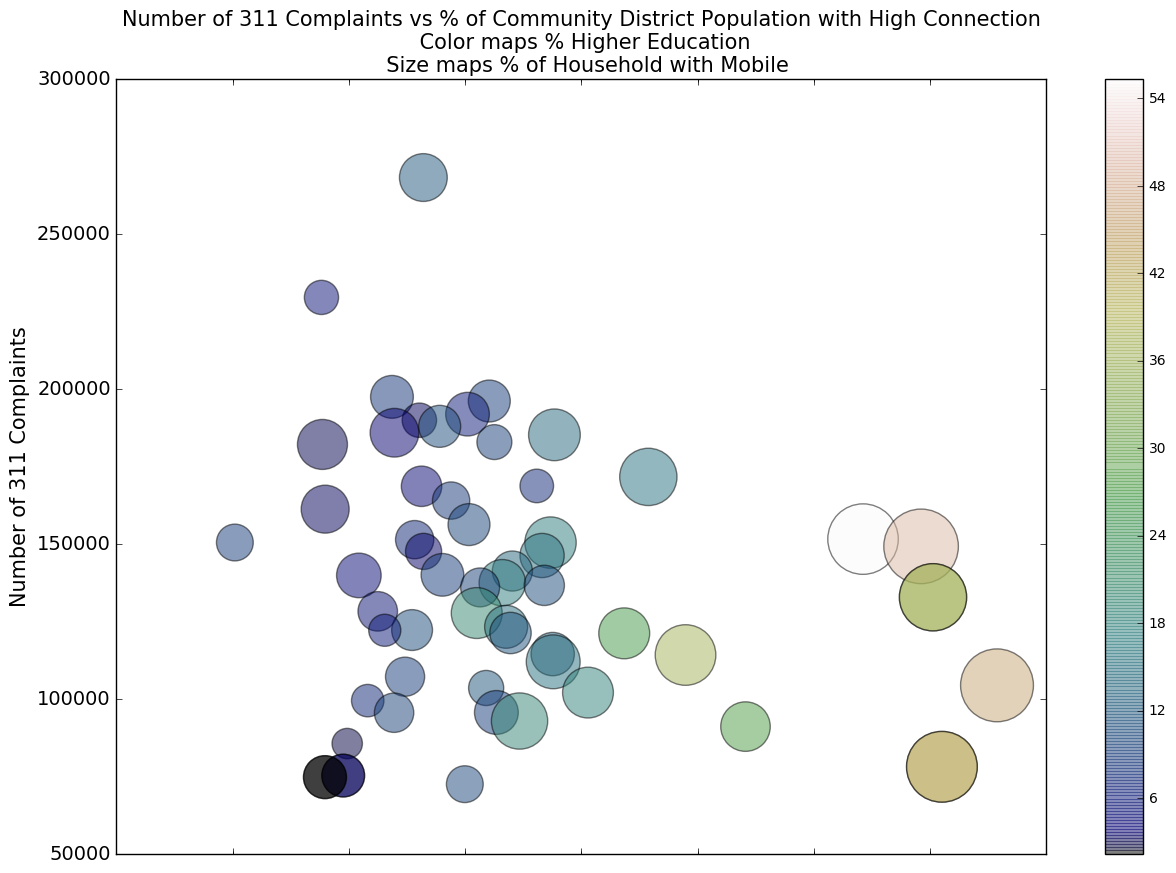

In [260]:
ax = pl.figure(figsize=(10,10))
d311_final.plot(kind='scatter', x='% high_connection', y='Number of Complaints', 
                fontsize=15, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(15, 10), 
                c = d311_final['% Higher Ed'], 
                s = d311_final['% With_Mobile']*100)
pl.title('Number of 311 Complaints vs % of Community District Population with High Connection\n \
Color maps % Higher Education\n  Size maps % of Household with Mobile', 
         fontsize=15)
pl.ylabel("Number of 311 Complaints", fontsize=15)
pl.xlabel("% of Community District with High Connection", fontsize=15)
pl.legend(loc='best')

### Figure 1
The plot above shows the number of complaints versus the % of households in the communty district with higher connection (x-axis).  This does not show only a slight correlation of increased number of complaints as the % of higher connection increases. Most of the districts cluster around the low-mid range of % of households with higher connection where the number of complaints increases with the % of households with mobile.  
Also plotted in color is the percentage of higher education in the community district.  As expected, community districts with higher education levels have higher connections.  Additionally, marked by the size of the cicles is the percentage of households with mobile, and as also can be expected, this is correlated with higher education.  Community Districts with higher number of complaints appear to be areas with lower percentage of higher education. The district with the lowest percentage of higher education has one of the lowest number of complaints The % of household in that district with mobile is average although the % of higher connection is significantly much lower.

In [257]:
d311_final.describe()

,Number of Complaints,% Higher Ed,% With_Mobile,% Without_Mobile,% high_connection,% low_connection
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,136197.491525,14.464648,11.689419,28.178241,27.113718,2.587647
std,41825.693968,12.878614,6.040485,4.072619,7.838594,1.005412
min,72362.000000,2.196869,4.788644,20.812597,15.096082,1.105000
25%,103822.500000,5.968698,7.991894,25.116215,21.952998,1.813118
50%,135833.000000,9.898700,9.561045,27.191706,25.498895,2.292203
75%,162464.500000,16.015645,13.408990,31.208838,28.719961,3.107526
max,268053.000000,55.349995,28.829913,37.789351,47.876860,5.206453


In [258]:
#dataset for reference
d311_final

,Number of Complaints,cd_id,% Higher Ed,% With_Mobile,% Without_Mobile,% high_connection,% low_connection
0,268053,MN12,12.128451,11.852116,23.154681,23.203708,3.127047
1,229383,QN12,5.261711,6.072063,26.228078,18.820966,3.244596
2,197306,BK03,8.283859,9.493001,32.301572,21.853117,4.507074
3,195961,QN07,9.150431,9.122387,26.214254,26.039760,1.105000
4,191720,BK17,6.017044,9.886131,29.425709,25.102890,1.698588
5,189765,BK05,3.245158,6.141291,31.507799,23.032407,2.157023
6,187794,BK14,10.975913,9.152128,27.355124,23.905092,2.242659
7,185729,BX07,3.741179,12.295703,24.847490,21.961396,4.620547
8,185057,BK01,14.052471,13.870198,29.178543,28.841145,3.130312
9,182713,SI01,9.591807,6.323651,30.180109,26.258662,1.260080
